In [4]:
import argparse
import gym
import random
import copy 
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from drawnow import drawnow
import matplotlib.pyplot as plt

from collections import deque
from torch.distributions import MultivariateNormal,Beta,Normal

from ride_hailing_env import RideHailingENV
from ride_hailing_location_model import Build_Model

import folium

C:\Users\zhh\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [20]:
import gym
import folium

import numpy as np
import pandas as pd

from gym import spaces
from folium.features import DivIcon
from IPython.display import display
from ride_hailing_match import Match
from ride_hailing_location_model import Build_Model
from pyproj import Transformer


Global_Resolution = 7 # change the resolution here, determines the number of cells
# !!!! change


def wgs84_to_xy(x_arr: np.ndarray, y_arr: np.ndarray):
    transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32614')
    x0 = 604082.94
    y0 = 3328141.76
    x_arr_new, y_arr_new = transformer.transform(x_arr, y_arr)
    x_arr_new -= x0
    y_arr_new -= y0
    return x_arr_new.tolist(), y_arr_new.tolist()

def xy_to_wgs84(xy_list):
    transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326')
    x_new = np.array(xy_list[0]) + 604082.94
    y_new = np.array(xy_list[1]) + 3328141.76
    lat_lon = transformer.transform(x_new, y_new)
    return lat_lon

def xy_to_wgs84_list(xy_list):
    transformer = Transformer.from_crs('EPSG:32614', 'EPSG:4326')
    x_arr = np.array(xy_list[0]) + 604082.94
    y_arr = np.array(xy_list[1]) + 3328141.76
    lat_list, lon_list = transformer.transform(x_arr, y_arr)
    return lat_list.tolist(), lon_list.tolist()


class Cell:
    """Gennerate cells
    """
    def __init__(self, num_divisions) -> None:
        self.lat_range = np.array([30.18, 30.32]) # Austin latitude range
        self.lon_range = np.array([-97.81, -97.65]) # Austin longitude range
        self.x_range, self.y_range = wgs84_to_xy(self.lat_range, self.lon_range)
        self.num_divisions = num_divisions # how many part lat and lon are divided
        pass
   
    def pass_info(self):
        return self.lat_range, self.lon_range, self.x_range, self.y_range, self.num_divisions
    
    def get_cells(self, display_map: bool = False) -> list:
        number =  self.num_divisions ** 2
        cells = np.arange(number)

        if display_map == False:
            return cells
        
        else:
            lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
            lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
            m = folium.Map(location=[(self.lat_range[0] + self.lat_range[1]) / 2, (self.lon_range[0] + self.lon_range[1]) / 2], zoom_start=13)
            for i in range(self.num_divisions):
                for j in range(self.num_divisions):
                    lat_start = self.lat_range[0] + i * lat_step
                    lat_end = lat_start + lat_step
                    lon_start = self.lon_range[0] + j * lon_step
                    lon_end = lon_start + lon_step
                    grid_number = i * self.num_divisions + j

                    # Draw the grid
                    folium.Rectangle(
                        bounds=[[lat_start, lon_start], [lat_end, lon_end]],
                        color='blue',
                        fill=True,
                        fill_opacity=0.1
                    ).add_to(m)

                    # Add grid number
                    folium.Marker(
                        location=[(lat_start + lat_end) / 2, (lon_start + lon_end) / 2],
                        icon=folium.DivIcon(html=f'<div style="font-size: 12pt">{grid_number}</div>')
                    ).add_to(m)

            # draw action range
            folium.Circle(
                radius=50,
                location=[(self.lat_range[1]-self.lat_range[0])/2+self.lat_range[0], (self.lon_range[1]-self.lon_range[0])/2+self.lon_range[0]],
                color="red",
                weight=5,
                fill=False,
            ).add_to(m)
            folium.Circle(
                radius=3000,
                location=[(self.lat_range[1]-self.lat_range[0])/2+self.lat_range[0], (self.lon_range[1]-self.lon_range[0])/2+self.lon_range[0]],
                color="red",
                weight=5,
                fill=False,
            ).add_to(m)

            display(m)
            return cells

    def get_cell_id_wgs84(self, lat, lon):
        if not (self.lat_range[0] <= lat <= self.lat_range[1]) or not (self.lon_range[0] <= lon <= self.lon_range[1]): # check if in the range
            return None
        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        lat_index = min(int((lat - self.lat_range[0]) / lat_step), self.num_divisions - 1)
        lon_index = min(int((lon - self.lon_range[0]) / lon_step), self.num_divisions - 1)
        grid_number = lat_index * self.num_divisions + lon_index
        return grid_number
    
    def get_cell_id_xy(self, x_list, y_list):
        cell_ids = []
        x_step = (self.x_range[1] - self.x_range[0]) / self.num_divisions
        y_step = (self.y_range[1] - self.y_range[0]) / self.num_divisions

        for x, y in zip(x_list, y_list):
            x_index = min(int((x - self.x_range[0]) / x_step), self.num_divisions - 1)
            y_index = min(int((y - self.y_range[0]) / y_step), self.num_divisions - 1)
            grid_number = x_index + y_index * self.num_divisions
            cell_ids.append(grid_number)
        
        return cell_ids
        

class Gen_Model:
    """Sample locations from fitted model for riders and drivers in the map

    This class is to generate locations for riders and drivers based on the given
    distribution of their locations. This default model is estimated with Kernel 
    Density Estimation (KDE). The generated location is given in the format of 
    a pandas DataFrame, each row represents a unique rider/driver. Information
    given in a row includes rider/driver's ID, H3 code, longitude and latitude.

    Attributes:
        model: an instance of Build_Model class containing models for riders and drivers
        rider_model: a dictionary for 24 KDE distributions, describing the locational and timely distribution of riders
        driver_model: a dictionary for 24 KDE distributions, describing the locational and timely distribution of drivers
    """
    def __init__(self, num_div) -> None:
        self.cell = Cell(num_div)
        self.cell_ids = self.cell.get_cells(False)
        self.model = Build_Model()
        self.rider_model, self.driver_model = self.model.get_model()

    def gen_drivers(self, number_of_drivers: int, hr_time: int, seed: int = None):
        """Sample locations for drivers
        
        Sample multiple locations for drivers based on the given locational distribution 
        of drivers. The default distribution model is KDE.

        Parameters:
            number_of_drivers: an int, indicating how many drivers are generated.
            hr_time: an int, the value is the hour of the day, indicating which distribution model will be used.
            resolution: an int, determines the number of cells in the map.

        Returns:
            driver_df: a pandas DataFrame, including information of generated drivers. 
        """
        if seed != None:
            driver_locations = self.model.sample_from_model(self.driver_model[f'{hr_time}'], number_of_drivers, seed) # dtype = numpy ndarray
        else:
            driver_locations = self.model.sample_from_model(self.driver_model[f'{hr_time}'], number_of_drivers) # dtype = numpy ndarray
        driver_ids = []
        cell_ids = []

        for driver_id, geo_info in enumerate(driver_locations):
            cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
            while cell_id is None:
                geo_info = self.model.sample_from_model(self.rider_model[f'{hr_time}'], 1)[0] # dtype = numpy ndarray
                cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
                driver_locations[driver_id] = geo_info
                #print('Re-sampled a driver!')
            cell_ids.append(cell_id)
            driver_ids.append(driver_id)

        x_list, y_list = wgs84_to_xy(driver_locations.T[0], driver_locations.T[1])

        driver_df = pd.DataFrame({'driver_id':driver_ids, 'cell_id':cell_ids, 'x':x_list, 'y':y_list, 'statue': 1, 'idle_time': 0})
        # driver is avliable: 'statue' = 1, unavliable: 'statue' = 0
        # driver_df[['driver_id', 'cell_id']] = driver_df[['driver_id', 'cell_id']].astype(int) # set data type to int

        return driver_df

    def gen_riders(self, number_of_riders: int, hr_time: int, seed: int = None):
        """Sample locations for riders
        
        Sample multiple locations for riders based on the given locational distribution 
        of riders. The default distribution model is KDE.

        Parameters:
            number_of_riders: an int, indicating how many riders are generated.
            hr_time: an int, the value is the hour of the day, indicating which distribution model will be used.
            resolution: an int, determines the number of cells in the map.

        Returns:
            rider_df: a pandas DataFrame, including information of generated riders. 
        """
        if seed != None:
            rider_locations = self.model.sample_from_model(self.rider_model[f'{hr_time}'], number_of_riders, seed) # dtype = numpy ndarray
        else:
            rider_locations = self.model.sample_from_model(self.rider_model[f'{hr_time}'], number_of_riders) # dtype = numpy ndarray
        rider_ids = []
        cell_ids = []
        
        for rider_id, geo_info in enumerate(rider_locations):
            cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
            while cell_id is None:
                geo_info = self.model.sample_from_model(self.rider_model[f'{hr_time}'], 1)[0] # dtype = numpy ndarray
                cell_id = self.cell.get_cell_id_wgs84(geo_info[0], geo_info[1])
                rider_locations[rider_id] = geo_info
                #print('Re-sampled a rider!')
            cell_ids.append(cell_id)
            rider_ids.append(rider_id)

        x_list, y_list = wgs84_to_xy(rider_locations.T[0], rider_locations.T[1])

        rider_df = pd.DataFrame({'rider_id':rider_ids, 'cell_id':cell_ids, 'x':x_list, 'y':y_list, 'time_step_in_pool': 1})
        # rider_df[['rider_id', 'cell_id', 'time_step_in_pool']] = rider_df[['rider_id', 'cell_id', 'time_step_in_pool']].astype(int) # set data type to int

        return rider_df



In [ ]:

class RideHailingENV(gym.Env):
    """Simulation environment for project optimising matching radius for ride-hailing system

    This class is the main simulator for the master thesis project optimising matching radius 
    for a ride-hailing system with reinforcement learning. The project is carried out in TU Delft. 
    This simulator is built base on the geographical information of Austin, Texas, USA. It intake
    continous matching radius as the action, and the reward is the total net profit made by the 
    system within a day.

    GOOD action for example:
    action = np.ones(36)*800
    action[[5, 13, 14, 15, 19, 20, 21, 26, 27]] = 400

    Attributes:
     lower_bound - lower bound of action space, minimum matching radius, unit is meters.
     upper_bound - upper bound of action space, maximum matching radius, unit is meters.
     model - make an instance of Gen_Model class, to generate riders and drivers for the simulator.
     match - make an instance of Match class, to run the matching algorithm.
     radius_initial - initial matching radius when reset the environment, unit is meters.
     driver_num_ini - initial number of drivers, can be changed if set dynamic.
     rider_num_ini - initial number of riders, rider number is changing among different steps.
     fuel_unit_price - average travelling fuel cost per vehicle per kilometer in the US, the unit is US dollars.
     time_window - time interval between every two matching process (Uber Batched matching), fixed among all steps, unit is minutes.
     total_reward - total reward for the intake action.
     gen_rate_rider - overall generating rate of riders, number of riders per time-window.
     gen_rate_driver - active if vehicle number are set dynamic, number of new drivers per time-window.
     ride_price - average ride price in Austin urban area, the value is estimated from Uber ride data in 2022.
     rider_patience - the maximum number of steps a rider can stay in the matching pool.
     p_unmatch_rider - penalty per unmatched rider, the value is cauculated base on the probability of losing a potential ride.
     action_space - defines the numerical range of intake actions.
     observation_space - defines the numerical range of overall observations.
     sub_observation_space - defines the numerical range of observations within a cell.

    Distance cost explain:
     distance cost = car-buying cost + car repair and maintanance cost + fuel cost
     car repair and maintanance cost = change tire per 200000km &1000 + change motor oil per 200000km $1200
     car-buying cost: average car price in the us is $22000
     fuel cost: averge fuel cost $1.3/L * averge fuel comsuption 9.3L/100km = $12.1/100km = $0.12/km
     total = $11.65/km
    """
    def __init__(self, grid_div, time_window: int = 0.25) -> None:

        lower_bound = 50
        upper_bound = 3000
        self.num_divi = grid_div
        self.cell = Cell(self.num_divi)
        self.lat_range, self.lon_range, self.x_range, self.y_range, self.num_divisions = self.cell.pass_info()
        self.model = Gen_Model(self.num_divi)
        self.match = Match()
        self.seed_ini = None

        self.cell_ids = self.cell.get_cells(False)
        self.cell_num = np.size(self.cell_ids)
        self.radius_initial = 500
        self.driver_num_ini = 100
        self.rider_num_ini = 15
        self.distance_cost = 13.26 * 0.001 # this is a combination of fuel cost, car-buying and car-repair cost, unit is per meter
        self.fuel_cost = 1.93 * 0.001
        self.time_window = time_window
        self.total_reward = 0
        self.gen_rate_rider = 10
        self.gen_rate_driver = 10
        self.ride_price = 23.92
        self.rider_patience = 5 # minutes
        self.p_rider_left = 0.1 # punishment
        self.p_unmatch_rider = 5
        self.simulation_time = 30

        self.drivers = None
        self.riders = None
        self.drivers_tmp = None
        self.riders_tmp = None

        self.score_distance = lambda distance, max_distance=2000: max(0, min(1, 1 - distance / max_distance))
        self.score_radius = lambda distance, max_distance=8000: max(0, min(1, 1 - distance / max_distance))
        self.score_radius_neg = lambda distance, max_distance=8000: max(0, min(1, distance / max_distance))
        self.score_diff = lambda distance, max_distance=1500: max(0, min(1, 1 - distance / max_distance))
        self.score_rate = lambda rate: 1 if rate > 0.85 else (0 if rate < 0.5 else (rate - 0.5) / 0.4)
        self.multi_task_weight_factor = [0.3, 0.6, 0.1] # order fulfillment rate, average pickup distance, driver utilization rate
        #self.multi_task_weight = [0.6, 0.4] # order fulfillment rate, average pickup distance

        self. rider_patience_step = self.rider_patience / self.time_window

        self.action_space = spaces.Box(
                low=np.array(lower_bound*np.ones(self.cell_num)), 
                high=np.array(upper_bound*np.ones(self.cell_num)),
                dtype=np.int32
                )
        self.observation_space = spaces.Discrete(self.num_divi ** 2) # updated

        self.step_count = 0
        self.max_step = self.simulation_time / self.time_window

    def reset(self, time_ini: int = 1) -> np.array:
        """
        reset the environment for the first step in every episode.

        Parameters:
         time_ini -  set the initial time to 0-1 hour of a day.

        Returns:
         returns the initial matching radius.
        """
        self.random_seed = self.seed_ini
        self.drivers = self.model.gen_drivers(self.driver_num_ini, time_ini, 1)
        self.drivers_in_service = np.zeros(self.driver_num_ini, dtype=np.int32)
        self.drivers['driver_id'] = np.arange(self.drivers.shape[0])

        self.riders = self.model.gen_riders(self.rider_num_ini, time_ini, self.random_seed)
        self.riders['rider_id'] = np.arange(self.riders.shape[0])

        done = False
        self.step_count = 0

        rider, driver, avg_dis = self.get_observe()
        self.matched_ride_num = 0
        self.ride_demand_num = self.rider_num_ini
        self.avg_distance_pf = 0
        self.driver_ult = 0
        self.radius_base = avg_dis
        self.action_ini = np.ones(self.cell_num) * 50
        state = np.ones(self.cell_num)*500

        return state, done #, self.riders, self.drivers
    
    def step(self, radius: np.array, hr_time: int, rend_step: bool = False) -> tuple[float, dict, list]:
        """
        The main process of a step.

        Parameters:
         radius - matching radius for each cell.
         hr_time - the hourly time step in a day, determines location distribution of riders and drivers.
         rend_step - visualize one step if set to True.

        Returns:
         the reward of one step and matched pairs within this step. 
        """

        #print(self.x_range, self.y_range, self.drivers)
        #self.random_seed += 1 # update seed
        self.action_ini = radius
        self.riders_tmp = self.riders.copy()
        self.drivers_tmp = self.drivers.copy()

        # get the distance matrix and matching pool
        cell_ids = self.riders['cell_id']
        r_radius = radius[cell_ids]

        # get the matching pool
        pool = self.__get_pool(self.dis_matrix, r_radius)

        # matching process
        match_statue = self.__match(pool)
        reward = self.__execute_match(match_statue, pool, radius)
        
        if rend_step:
            state = [self.riders_tmp, self.drivers_tmp]
            self.render(state, radius, match_statue)

        self.riders, self.drivers, reward, done = self.__state_transit(hr_time, reward, match_statue)

        # give terminal reward
        if done == True:
            reward += 0 #100
        else:
            reward -= 0 #len(self.riders)
            self.step_count += 1

        rider, driver, avg_dis = self.get_observe()
        return rider, driver, avg_dis, reward, done
    
    def get_observe(self): # observation is number of riders/drivers in each cell

        # new version observation, according to ref: cell num, time_step, previoud radius, number of drivers, number of riders
        rider_counts = self.riders['cell_id'].value_counts().sort_index().reindex(range(self.cell_num), fill_value=0).to_numpy()
        supply_driver = self.drivers[self.drivers['statue']==1]
        driver_counts = supply_driver['cell_id'].value_counts().sort_index().reindex(range(self.cell_num), fill_value=0).to_numpy()

        avg_distance = np.full(self.cell_num, 0)  # Initialize with 6000 for cells with no riders

        rider_vec = self.riders[['x', 'y']].values
        driver_vec = self.drivers[['x', 'y']].values

        # get the distance matrix and matching pool
        self.dis_matrix = self.__vector_dis(rider_vec, driver_vec)

        # Calculate the minimum distance from each rider to any driver
        for cell_id in range(self.cell_num):
            riders_in_cell = self.riders[self.riders['cell_id'] == cell_id].index
            if len(riders_in_cell) > 0:
                distances = self.dis_matrix[riders_in_cell].min(axis=1)
                distance = distances.mean()
                avg_distance[cell_id] = distance
        
        self.avg_distance = np.clip(avg_distance, 0, 2500)
        self.diff = abs(self.action_ini - self.radius_base)

        return rider_counts, driver_counts, self.avg_distance, self.diff
    
    def check_done(self):
        if self.step_count >= self.max_step -1: #or self.riders.shape[0] == 0:
            done = True
        else:
            done = False
        return done

    def __get_pool(self, dis_matrix: np.matrix, radius_set: int) -> np.ndarray:
        """
        form a matching pool for all the riders and available drivers whithin the matching radius.

        Parameters:
            riders - locations, numbers of all the riders.
            drivers - locations, numbers of all the drivers.
            radius - matching radius for each cell, riders in the same cell have the same matching radius.

        Returns:
            returns a list consist all the possible matches and the distance between them.
        """
        match_pool = []
        for i in range(dis_matrix.shape[0]):
            sub_pool = []
            radius_rider = radius_set[i]
            driver_1 = np.where(dis_matrix[i] <= radius_rider)[1]
            driver_2 = self.drivers.index[self.drivers['statue'] == 1]
            driver = list(np.intersect1d(driver_1, driver_2))
            rider = list(np.ones(np.size(driver), dtype=int)*i)
            dis = dis_matrix[i, driver].tolist()[0]
            sub_pool.extend([rider])
            sub_pool.extend([driver])
            sub_pool.extend([dis])
            sub_pool = list(map(list, zip(*sub_pool)))
            match_pool.extend(sub_pool)
        return match_pool
            
    def __match(self, pool: list): # MM: Maximum Matching, OM: Optimised Matching
        """
        excute matching algorithm to find the optimal match for the given matching pool.

        Parameters:
         pool - matching pool with distance. 

        Returns:
         match statue with matched pairs and their distance. 
        """
        matched_pairs = self.match.match(pool, method='Munkres')
        return matched_pairs
    
    def __execute_match(self, match_statue:list, match_pool: list, radius: np.array) -> tuple[float, tuple]:
        """
        apply the matched pairs to the map, update riders and drivers, observe reward and penalty.

        Parameters:
        riders - locations, numbers of all the riders.
        drivers - locations, numbers of all the drivers.
        match_statue - matched pair of riders and drivers with the distance between them.

        Returns:
        reward - the net monetary profit made from the ride-hailing system within a step.
        pool_next - next state of the environment after taking the action.
        """
        # calculate total distance and rewards
        reward = 0 #- 200 * self.distance_cost
        complete_rate = self.score_rate(len(match_statue) / len(self.riders))
        self.matched_ride_num += len(match_statue)
        self.driver_ult += len(match_statue) / len(self.drivers[self.drivers['statue']==1])

        if match_statue:
            aver_distance = sum(distance for _, _, distance in match_statue) / len(match_statue)
            riders_to_drop, drivers_to_drop = zip(*[(rider, driver) for rider, driver, _ in match_statue])
            riders_to_drop, drivers_to_drop = list(riders_to_drop), list(drivers_to_drop)
            #reward_match_rate = len(match_statue) / len(self.riders)
            #reward_driver_ult = len(match_statue) / len(match_pool)
        else:
            aver_distance = 0 # in case for tricky policies
            riders_to_drop, drivers_to_drop = [], []
            #reward_match_rate = 0
            #reward_driver_ult = 0
                 
        #reward_distance = self.score_distance(aver_distance)
        self.avg_distance_pf += aver_distance
        #print(complete_rate, reward_distance, reward_driver_ult)
        #reward_diff = abs(radius - self.avg_distance)
        base_radius_diff = sum(self.diff)

        #reward = complete_rate * self.multi_task_weight_factor[0] + reward_distance * self.multi_task_weight_factor[1] + reward_driver_ult * self.multi_task_weight_factor[2]
        #reward = complete_rate * self.multi_task_weight_factor[0] + self.score_diff(sum(reward_diff)/self.cell_num) * self.multi_task_weight_factor[1]
        #reward = self.score_diff(sum(reward_diff)/self.cell_num) * self.multi_task_weight_factor[1]
        #reward = complete_rate * self.multi_task_weight_factor[0] - self.score_radius_neg(sum(radius)) * self.multi_task_weight_factor[1]
        #reward = complete_rate * self.multi_task_weight_factor[0]
        reward = complete_rate * self.multi_task_weight_factor[0] + self.score_diff(sum(base_radius_diff)) * self.multi_task_weight_factor[1]

        self.riders = self.riders.drop(riders_to_drop)
        self.drivers_in_service[drivers_to_drop] += 2
        self.drivers.loc[drivers_to_drop, 'statue'] = 0
        self.drivers.loc[drivers_to_drop, 'idle_time'] = 0

        self.riders['time_step_in_pool'] += 1
        self.riders = self.riders.drop(self.riders[self.riders['time_step_in_pool']>self.rider_patience_step].index) # inpatient riders quit the matching pool

        # calculate net reward
        net_reward = reward

        return net_reward
    
    def __vector_dis(self, rider_vec, driver_vec):
        m = np.shape(rider_vec)[0]
        n = np.shape(driver_vec)[0]
        M = np.dot(rider_vec, driver_vec.T)
        H = np.tile(np.matrix(np.square(rider_vec).sum(axis=1)).T,(1,n))
        K = np.tile(np.matrix(np.square(driver_vec).sum(axis=1)),(m,1))
        return np.sqrt(-2 * M + H + K)
    
    def __state_transit(self, hr_time: int, reward: float, match_statue: list) -> dict: 
        """
        update the current state and give the state of the next step.
        v1_update: do not gennerate new riders, terminal is all the riders are matched or left

        Parameters:
         state - the current state, locations of riders and drivers.
         hr_time - hourly time of a day, this is used to generate new riders and drivers.

        Returns:
         returns the locations of riders and drivers for the next step.
        """
        ride_num = np.size(match_statue)

        # update riders
        done = self.check_done()
        if done == True:
            self.riders = self.riders.reset_index(drop=True)
            self.drivers = self.drivers.reset_index(drop=True)
            # re-index drivers and riders
            driver_index = self.drivers.shape[0]
            self.drivers['driver_id'] = np.arange(driver_index)
            rider_index = self.riders.shape[0]
            self.riders['rider_id'] = np.arange(rider_index)

            return self.riders, self.drivers, reward, done

        rider_size = self.gen_rate_rider
        self.ride_demand_num += rider_size
        new_riders = self.model.gen_riders(rider_size, hr_time, self.random_seed)
        rider_next = pd.concat((self.riders, new_riders), axis=0)

        self.drivers.loc[self.drivers_in_service == 0, 'statue'] = 1 # drivers finished ride

        # update drivers - driver reposition
        self.drivers.loc[self.drivers['statue'] == 1, 'idle_time'] += 1 # update idle time
        condition = (self.drivers['idle_time'] == 20) & (self.drivers['statue'] == 1)
        self.drivers.loc[condition, 'x'] += np.random.choice([-800, 800], size=condition.sum())
        self.drivers.loc[condition, 'y'] += np.random.choice([-800, 800], size=condition.sum())
        self.drivers.loc[condition, 'idle_time'] = 0 # reset idle time

        # update drivers - driver idling
        self.drivers_in_service[self.drivers_in_service != 0] -= 1
        self.drivers['x'] += np.random.uniform(-400, 400, size=self.drivers.shape[0])
        self.drivers['y'] += np.random.uniform(-400, 400, size=self.drivers.shape[0])

        # check latitude and longitude border
        self.drivers['x'] = np.clip(self.drivers['x'], self.x_range[0], self.x_range[1]) # check latitude range
        self.drivers['y'] = np.clip(self.drivers['y'], self.y_range[0], self.y_range[1]) # check longitude range

        # update cell ids for drivers
        self.drivers['cell_id'] = self.cell.get_cell_id_xy(self.drivers['x'], self.drivers['y']) 

        #rider_next = rider_next.reset_index(drop=True)
        self.riders = rider_next.reset_index(drop=True)
        self.drivers = self.drivers.reset_index(drop=True)

        # re-index drivers and riders
        driver_index = self.drivers.shape[0]
        self.drivers['driver_id'] = np.arange(driver_index)
        rider_index = self.riders.shape[0]
        self.riders['rider_id'] = np.arange(rider_index)

        return self.riders, self.drivers, reward, done
    
    def get_performance_statue(self):
        match_rate = self.matched_ride_num / (self.ride_demand_num - self.gen_rate_rider)
        avg_pick_distance = self.avg_distance_pf / self.step_count
        driver_ult = self.driver_ult / self.step_count
        return match_rate, avg_pick_distance, driver_ult

    def render(self, state: tuple, radius_set: dict, match_statue: list, color_set: tuple = ['red', 'blue'], folium_map=None) -> None:
        """
        visualise the state and action for one step, red circle is matching range (within matching radius),
        green lines are the links for matched pairs.

        Parameters:
         state - the current state, locations of riders and drivers.
         radius_set - matching radius for each cell.
         match_statue - matched pair of riders and drivers with the distance between them.
         folium_map - map object.
        """

        riders = state[0]
        drivers = state[1]
        drivers = drivers[drivers['statue'] == 1]
        drivers.reset_index(drop=True, inplace=True)
        matched_riders = []
        matched_drivers = []
        if match_statue != []:
            matched_riders = pd.DataFrame(match_statue)[0].to_list()
            matched_drivers = pd.DataFrame(match_statue)[1].to_list()

        matched_rider_location = {}
        matched_driver_location = {}

        lat_step = (self.lat_range[1] - self.lat_range[0]) / self.num_divisions
        lon_step = (self.lon_range[1] - self.lon_range[0]) / self.num_divisions
        m = folium.Map(location=[(self.lat_range[0] + self.lat_range[1]) / 2, (self.lon_range[0] + self.lon_range[1]) / 2], zoom_start=13)
        for i in range(self.num_divisions):
            for j in range(self.num_divisions):
                lat_start = self.lat_range[0] + i * lat_step
                lat_end = lat_start + lat_step
                lon_start = self.lon_range[0] + j * lon_step
                lon_end = lon_start + lon_step
                grid_number = i * self.num_divisions + j
                # Draw the grid
                folium.Rectangle(
                    bounds=[[lat_start, lon_start], [lat_end, lon_end]],
                    color='blue',
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)
                # Add grid number
                folium.Marker(
                    location=[(lat_start + lat_end) / 2, (lon_start + lon_end) / 2],
                    icon=folium.DivIcon(html=f'<div style="font-size: 18pt">{grid_number}</div>')
                ).add_to(m)
       
        # add driver markers
        for i in range(drivers.shape[0]):
            driver_wgs = xy_to_wgs84([drivers.loc[i]['x'], drivers.loc[i]['y']])
            folium.Marker(
                location=driver_wgs,
                icon=folium.Icon(
                    color=color_set[0],
                    prefix='fa',
                    icon='car'
                    )
                ).add_to(m)
            if drivers.loc[i]['driver_id'] in matched_drivers:
                matched_driver_location[f'{int(drivers.loc[i]["driver_id"])}'] = driver_wgs
          
        # add rider markers and matching radius
        for j in range(riders.shape[0]):
            rider_wgs = xy_to_wgs84([riders.loc[j]['x'], riders.loc[j]['y']])
            folium.Marker(
                location=rider_wgs,
                icon=folium.Icon(
                    color=color_set[1],
                    prefix='fa',
                    icon='male'
                    )
                ).add_to(m)
            
            folium.Circle(
                    radius=float(radius_set[int(riders.loc[j]['cell_id'])]),
                    location=rider_wgs,
                    color="red",
                    weight=1,
                    fill=True,
                    fill_opacity=0.1
                ).add_to(m)
            if riders.loc[j]['rider_id'] in matched_riders:
                matched_rider_location[f'{int(riders.loc[j]["rider_id"])}'] = rider_wgs
       
        for rider, driver, dis in match_statue:
            folium.PolyLine(
                locations=[matched_rider_location[f'{int(rider)}'], matched_driver_location[f'{int(driver)}']],
                color='green', 
                weight=5,
                tooltip='matched_links'
                ).add_to(m)
    
        display(m)
        pass

In [95]:
class Memory(object):
  def __init__(self, memory_size=10000):
    self.memory = deque(maxlen=memory_size)
    self.memory_size = memory_size

  def __len__(self):
    return len(self.memory)

  def append(self, item):
    self.memory.append(item)

  def sample_batch(self, batch_size):
    idx = np.random.permutation(len(self.memory))[:batch_size]
    return [self.memory[i] for i in idx]

# Simple Ornstein-Uhlenbeck Noise generator
class OUNoise(object):
  """ Ornstein-Uhlenbeck process noise """
  def __init__(self, size, mu=0.0, theta=0.1, sigma=0.1):
        """ Initialize parameters and noise process """
        self.mu = mu * np.ones(size)
        self.theta = theta 
        self.sigma = sigma
        self.size = size
        self.reset()

  def reset(self):
        """ Reset the interal state (= noise) to mean (mu). """
        self.state = copy.copy(self.mu)

  def sample(self):
        """ Update internal state and return it as a noise sample """
        self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.standard_normal(self.size)
        return self.state


class Actor(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(Actor, self).__init__()
    self.fc_1 = nn.Linear(state_dim, 64)
    self.fc_2 = nn.Linear(64, 32)
    self.fc_out = nn.Linear(32, action_dim, bias=False)
    init.xavier_normal_(self.fc_1.weight)
    init.xavier_normal_(self.fc_2.weight)
    init.xavier_normal_(self.fc_out.weight)

  def forward(self, x):
    out = F.elu(self.fc_1(x))
    out = F.elu(self.fc_2(out))
    out = F.tanh(self.fc_out(out))
    return out


class Critic(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    self.fc_state = nn.Linear(state_dim, 32)
    self.fc_action = nn.Linear(action_dim, 32)
    self.fc = nn.Linear(64, 128)
    self.fc_value = nn.Linear(128, 1, bias=False)
    init.xavier_normal_(self.fc_state.weight)
    init.xavier_normal_(self.fc_action.weight)
    init.xavier_normal_(self.fc.weight)
    init.xavier_normal_(self.fc_value.weight)

  def forward(self, state, action):
    out_s = F.elu(self.fc_state(state))
    out_a = F.elu(self.fc_action(action))
    out = torch.cat([out_s, out_a], dim=1)
    out = F.elu(self.fc(out))
    out = self.fc_value(out)
    return out


class DDPG:
  def __init__(self, args) -> None:
    self.args = args
    self.env = gym.make('MountainCarContinuous-v0')
    self.action_dim = self.env.action_space.shape[0]
    self.state_dim = self.env.observation_space.shape[0]

    self.actor = Actor(self.state_dim, self.action_dim)
    self.critic = Critic(self.state_dim, self.action_dim)
    self.actor_target = Actor(self.state_dim, self.action_dim)
    self.critic_target = Critic(self.state_dim, self.action_dim)

    self.actor_target.load_state_dict(self.actor.state_dict()) # initial target net weights from policy net
    self.critic_target.load_state_dict(self.critic.state_dict()) # initial target net weights from value net

    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.args.lr)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.args.lr)

    self.max_action = self.env.action_space.high[0]
    self.min_action = self.env.action_space.low[0]

    self.noise = OUNoise(size=1, theta=0.15, sigma=0.2) # import noise

    self.last_score_plot = [0]
    self.avg_score_plot = [0]

    self.memory_main = Memory(memory_size=10000)
    self.memory_good_act = Memory(memory_size=10000)

    self.loss_check = []
    self.rider_num = []
    
    pass

  def get_action(self, actor_net, state):
    if not isinstance(state, torch.Tensor):
      state = torch.from_numpy(state).float()
    action = actor_net(state)
    return action
  
  def get_radius(self, action): # re-scale action
    radius = action * self.scale + self.axis
    return radius

  def get_q_value(self, critic_net, state, action):
    if not isinstance(state, torch.Tensor):
      state = torch.from_numpy(state).float()
    if not isinstance(action, torch.Tensor):
      action = torch.from_numpy(action).float()
    q_value = critic_net(state, action)
    return q_value

  def update_actor(self, state):
    action = self.actor(state)
    #action = torch.clamp(action, float(self.min_action), float(self.max_action))
    q_value = -torch.mean(self.critic(state, action)) 
    self.actor_optimizer.zero_grad() # calculate the gradient to update actor
    q_value.backward()
    self.actor_optimizer.step()
    pass

  def update_critic(self, state, action, target):
    q_value = self.critic(state, action)
    loss = F.mse_loss(q_value, target) # minimize loss to update critic
    self.critic_optimizer.zero_grad()
    loss.backward()
    self.critic_optimizer.step()
    #check = loss.detach().numpy()
    #self.loss_check.append(check)
    pass

  def soft_update(self, target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
      target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau) # weights target and source

  def draw_fig(self):
    plt.plot(self.last_score_plot, '-')
    plt.plot(self.avg_score_plot, 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reinforcement Learning Process')
    plt.grid(True)
    plt.show()

  def run_ddpg(self):
    state = self.env.reset()[0]

    iteration_now = 0
    iteration = 0
    episode = 0
    episode_score = 0
    episode_steps = 0

    memory_warmup = self.args.batch_size * 3

    while episode < self.args.max_episode:
      print('\rIteration {} | Episode {} | Result -> '.format(iteration_now, episode), end='')
      #action = np.array([1, 1, 1, 1, 1, 1, 1])
      action = self.get_action(self.actor, state).detach().numpy()

      # blend determinstic action with random action during exploration, noise will become samller during the process
      if episode < self.args.max_explore_eps:
        p = episode / self.args.max_explore_eps
        action = action * p + (1 - p) * self.noise.sample()[0]

      action = np.clip(action, self.min_action, self.max_action) # select valid action range

      next_state, reward, done, _, _ = self.env.step(action)
      reward = reward# re-sacle the reward for plot
      self.memory_main.append([state, action, reward, next_state, done])
      if reward > -0.001:
        self.memory_good_act.append([state, action, reward, next_state, done]) # memory for good actions

      if iteration >= memory_warmup:
        memory_batch_0 = self.memory_main.sample_batch(int(self.args.batch_size * 0.7))
        memory_batch_1 = self.memory_good_act.sample_batch(int(self.args.batch_size * 0.3))
        memory_batch = memory_batch_0 + memory_batch_1

        memory_batch = self.memory_main.sample_batch(int(self.args.batch_size))

        state_batch, action_batch, reward_batch, next_state_batch, done_batch = map(lambda x: torch.tensor(x).float(), zip(*memory_batch))

        action_next = self.get_action(self.actor_target, next_state_batch)

        # using discounted reward as target q-value to update critic
        Q_next = self.get_q_value(self.critic_target, next_state_batch, action_next).detach()
        Q_target_batch = reward_batch[:, None] + self.args.gamma * (1 - done_batch[:, None]) * Q_next
        self.update_critic(state_batch, action_batch, Q_target_batch)
        self.update_actor(state_batch)

        # soft update
        self.soft_update(self.actor_target, self.actor, self.args.tau)
        self.soft_update(self.critic_target, self.critic, self.args.tau)

      episode_score += reward
      episode_steps += 1
      iteration_now += 1
      iteration += 1

      if done:
        print('Episode {:03d} | Episode Score:{:.03f} | steps {}'.format(episode, episode_score, episode_steps))
        #print(f'Policy now: {radius}')
        self.avg_score_plot.append(self.avg_score_plot[-1] * 0.99 + episode_score * 0.01)
        self.last_score_plot.append(episode_score)

        episode += 1
        episode_score = 0
        episode_steps = 0
        iteration_now = 0

        state = self.env.reset()[0]
        self.noise.reset()
        self.rider_num=[]
      else:
        state = next_state # state tranist

    #drawnow(self.draw_fig) # drawnow function is for dynamic update
    self.draw_fig()
    return state, self.actor
  
  def debug_info(self):
    return self.loss_check

Iteration 971 | Episode 0 | Result -> Episode 000 | Episode Score:87.614 | steps 972
Iteration 629 | Episode 1 | Result -> Episode 001 | Episode Score:90.808 | steps 630
Iteration 723 | Episode 2 | Result -> Episode 002 | Episode Score:89.317 | steps 724
Iteration 469 | Episode 3 | Result -> Episode 003 | Episode Score:92.849 | steps 470
Iteration 1901 | Episode 4 | Result -> Episode 004 | Episode Score:75.390 | steps 1902
Iteration 2717 | Episode 5 | Result -> Episode 005 | Episode Score:64.759 | steps 2718
Iteration 1288 | Episode 6 | Result -> Episode 006 | Episode Score:82.557 | steps 1289
Iteration 1903 | Episode 7 | Result -> Episode 007 | Episode Score:70.873 | steps 1904
Iteration 1236 | Episode 8 | Result -> Episode 008 | Episode Score:82.390 | steps 1237
Iteration 727 | Episode 9 | Result -> Episode 009 | Episode Score:91.324 | steps 728
Iteration 2158 | Episode 10 | Result -> Episode 010 | Episode Score:72.895 | steps 2159
Iteration 911 | Episode 11 | Result -> Episode 011 |

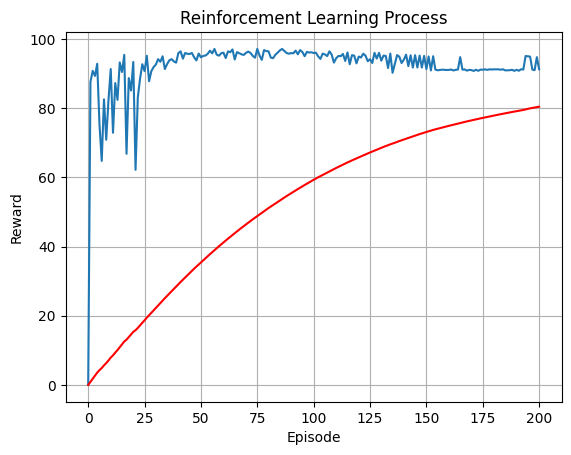

(array([-0.43750325,  0.        ], dtype=float32),
 Actor(
   (fc_1): Linear(in_features=2, out_features=64, bias=True)
   (fc_2): Linear(in_features=64, out_features=32, bias=True)
   (fc_out): Linear(in_features=32, out_features=1, bias=False)
 ))

In [98]:
parser = argparse.ArgumentParser(description='PyTorch DDPG solution of Ride_hailing Radius')

parser.add_argument('--gamma', type=float, default=0.99)
parser.add_argument('--lr', type=float, default=0.0001) #!
parser.add_argument('--tau', type=float, default=0.001) # critic output weights between critic and target networks
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--max_episode', type=int, default=200)
parser.add_argument('--max_explore_eps', type=int, default=150)

args = parser.parse_args(args=[])

ddpg = DDPG(args)
ddpg.run_ddpg()

In [42]:
a = np.array([1, 4, 7])
b = np.array([3, 3, 3])

a[a > b] = b[a > b]
a

array([1, 3, 3])

In [55]:
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils


class SimpleEnv(gym.Env):
    def __init__(self, render_mode: Optional[str] = None):
        self.min_action = np.ones(9)*(-10)
        self.max_action = np.ones(9)*(10)
        self.min_position = -100
        self.max_position = 1500
        self.min_speed = -10
        self.max_speed = 10
        self.goal_position = [500, 100, 120, 1000, 700, 600, 300, 400, 200]
        self.power = 0.0015

        self.low_state = np.ones(9)*self.min_position
        self.high_state = np.ones(9)*self.max_position


        self.action_space = spaces.Box(
            low=self.min_action, high=self.max_action, shape=(9,), dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=self.low_state, high=self.high_state, dtype=np.float32
        )

    def step(self, action: np.ndarray):

        position = self.state

        position += action * 100

        position[position > self.high_state] = self.high_state[position > self.high_state]
        position[position < self.low_state] = self.low_state[position < self.low_state]

        # Convert a possible numpy bool to a Python bool.
        terminated = bool(
            (position >= self.goal_position).all()
        )
        reward = 0
        if terminated:
            reward = 100.0
        reward -= math.pow(sum(action), 2) * 0.001
        self.state = position

        return self.state, reward, terminated

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        self.state = np.random.uniform(low=self.min_position, high=self.max_position, size=9)
        return self.state

In [56]:
class Memory(object):
  def __init__(self, memory_size=10000):
    self.memory = deque(maxlen=memory_size)
    self.memory_size = memory_size

  def __len__(self):
    return len(self.memory)

  def append(self, item):
    self.memory.append(item)

  def sample_batch(self, batch_size):
    idx = np.random.permutation(len(self.memory))[:batch_size]
    return [self.memory[i] for i in idx]

# Simple Ornstein-Uhlenbeck Noise generator
class OUNoise(object):
  """ Ornstein-Uhlenbeck process noise """
  def __init__(self, size, mu=0.0, theta=0.1, sigma=0.1):
        """ Initialize parameters and noise process """
        self.mu = mu * np.ones(size)
        self.theta = theta 
        self.sigma = sigma
        self.size = size
        self.reset()

  def reset(self):
        """ Reset the interal state (= noise) to mean (mu). """
        self.state = copy.copy(self.mu)

  def sample(self):
        """ Update internal state and return it as a noise sample """
        self.state += self.theta * (self.mu - self.state) + self.sigma * np.random.standard_normal(self.size)
        return self.state


class Actor(nn.Module):
  def __init__(self, state_dim=1, action_dim=20):
    super(Actor, self).__init__()
    self.fc_1 = nn.Linear(state_dim, 32)
    self.fc_2 = nn.Linear(32, 16)
    self.fc_out = nn.Linear(16, action_dim, bias=False)
    init.xavier_normal_(self.fc_1.weight)
    init.xavier_normal_(self.fc_2.weight)
    init.xavier_normal_(self.fc_out.weight)

  def forward(self, x):
    out = F.elu(self.fc_1(x))
    out = F.elu(self.fc_2(out))
    out = F.tanh(self.fc_out(out))
    return out


class Critic(nn.Module):
  def __init__(self, state_dim=1, action_dim=20):
    super(Critic, self).__init__()
    self.fc_state = nn.Linear(state_dim, 16)
    self.fc_action = nn.Linear(action_dim, 16)
    self.fc = nn.Linear(32, 32)
    self.fc_value = nn.Linear(32, 1, bias=False)
    init.xavier_normal_(self.fc_state.weight)
    init.xavier_normal_(self.fc_action.weight)
    init.xavier_normal_(self.fc.weight)
    init.xavier_normal_(self.fc_value.weight)

  def forward(self, state, action):
    out_s = F.elu(self.fc_state(state))
    out_a = F.elu(self.fc_action(action))
    out = torch.cat([out_s, out_a], dim=1)
    out = F.elu(self.fc(out))
    out = self.fc_value(out)
    return out


class DDPG:
  def __init__(self, args) -> None:
    self.args = args
    self.env = SimpleEnv()
    self.action_dim = self.env.action_space.shape[0]
    self.state_dim = self.env.observation_space.shape[0]

    self.actor = Actor(self.state_dim, self.action_dim)
    self.critic = Critic(self.state_dim, self.action_dim)
    self.actor_target = Actor(self.state_dim, self.action_dim)
    self.critic_target = Critic(self.state_dim, self.action_dim)
    self.actor_target.load_state_dict(self.actor.state_dict()) # initial target net weights from policy net
    self.critic_target.load_state_dict(self.critic.state_dict()) # initial target net weights from value net
    self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.args.lr)
    self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.args.lr)
    
    self.max_action = self.env.action_space.high[0]
    self.min_action = self.env.action_space.low[0]
    self.axis = (self.min_action + self.max_action) / 2
    self.scale = (self.min_action - self.max_action) / 2
    self.noise = OUNoise(self.action_dim, theta=0.15, sigma=0.1) # import noise # smaller noise
    # hex smaller hexagons and change res

    self.last_score_plot = [0]
    self.avg_score_plot = [0]

    self.memory_main = Memory(memory_size=5000)
    self.memory_good_act = Memory(memory_size=5000)

    self.loss_check = []
    self.rider_num = []

    pass

  def get_action(self, actor_net, state):
      if not isinstance(state, torch.Tensor):
        state = torch.from_numpy(state).float()
      action = actor_net(state)
      return action
    

  def get_q_value(self, critic_net, state, action):
    if not isinstance(state, torch.Tensor):
      state = torch.from_numpy(state).float()
    if not isinstance(action, torch.Tensor):
      action = torch.from_numpy(action).float()
    q_value = critic_net(state, action)
    return q_value

  def update_actor(self, state):
    action = self.actor(state)
    #action = torch.clamp(action, float(self.min_action), float(self.max_action))
    q_value = -torch.mean(self.critic(state, action)) 
    self.actor_optimizer.zero_grad() # calculate the gradient to update actor
    q_value.backward()
    self.actor_optimizer.step()
    pass

  def update_critic(self, state, action, target):
    q_value = self.critic(state, action)
    loss = F.mse_loss(q_value, target) # minimize loss to update critic
    self.critic_optimizer.zero_grad()
    loss.backward()
    self.critic_optimizer.step()
    check = loss.detach().numpy()
    self.loss_check.append(check)
    pass

  def soft_update(self, target, source, tau):
    for target_param, param in zip(target.parameters(), source.parameters()):
      target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau) # weights target and source

  def draw_fig(self):
    plt.plot(self.last_score_plot, '-')
    plt.plot(self.avg_score_plot, 'r-')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reinforcement Learning Process')
    plt.grid(True)
    plt.show()

  def run_ddpg(self):
    state = self.env.reset()

    iteration_now = 0
    iteration = 0
    episode = 0
    episode_score = 0
    episode_steps = 0

    memory_warmup = self.args.batch_size * 3

    self.noise.reset()

    while episode < self.args.max_episode:
      print('\rIteration {} | Episode {} | Result -> '.format(iteration_now, episode), end='')
      #action = np.array([1, 1, 1, 1, 1, 1, 1])
      action = self.get_action(self.actor, state).detach().numpy()

      # blend determinstic action with random action during exploration, noise will become samller during the process
      if episode < self.args.max_explore_eps:
        p = episode / self.args.max_explore_eps
        action = action * p + (1 - p) * self.noise.sample()
        #action = action* 0.5 + 0.5 * self.noise.sample()
      self.rider_num.append(state[0])
      action = np.clip(action, -1, 1) # select valid action range
      next_state, reward, done = self.env.step(action)
      reward = reward # re-sacle the reward for plot
      self.memory_main.append([state, action, reward, next_state, done])

      if iteration >= memory_warmup:
        memory_batch = self.memory_main.sample_batch(int(self.args.batch_size))
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = map(lambda x: torch.tensor(x).float(), zip(*memory_batch))
        action_next = self.get_action(self.actor_target, next_state_batch)

        # using discounted reward as target q-value to update critic
        Q_next = self.get_q_value(self.critic_target, next_state_batch, action_next).detach()
        Q_target_batch = reward_batch[:, None] + self.args.gamma * (1 - done_batch[:, None]) * Q_next
        self.update_critic(state_batch, action_batch, Q_target_batch)
        self.update_actor(state_batch)

        # soft update
        self.soft_update(self.actor_target, self.actor, self.args.tau)
        self.soft_update(self.critic_target, self.critic, self.args.tau)

      episode_score += reward
      episode_steps += 1
      iteration_now += 1
      iteration += 1

      if done:
        print('Episode {:03d} | Episode Score:{:.03f} | steps {}'.format(episode, episode_score, episode_steps))
        #print(f'Policy now: {radius}')
        self.avg_score_plot.append(self.avg_score_plot[-1] * 0.99 + episode_score * 0.01)
        self.last_score_plot.append(episode_score)

        episode += 1
        episode_score = 0
        episode_steps = 0
        iteration_now = 0

        state = self.env.reset()
        self.noise.reset()

        #plt.plot(self.rider_num, '-')
        #plt.show()
        self.rider_num=[]
      else:
        state = next_state # state tranist

    #drawnow(self.draw_fig) # drawnow function is for dynamic update
    self.draw_fig()
    return state, self.actor
  
  def debug_info(self):
    return self.loss_check

In [57]:
parser = argparse.ArgumentParser(description='PyTorch DDPG solution of Ride_hailing Radius')
parser.add_argument('--gamma', type=float, default=0.99)
parser.add_argument('--lr', type=float, default=0.0001) # default 0.0001
parser.add_argument('--tau', type=float, default=0.001) # critic output weights between critic and target networks, default 0.001
parser.add_argument('--batch_size', type=int, default=100)
parser.add_argument('--max_episode', type=int, default=200)
parser.add_argument('--max_explore_eps', type=int, default=150)
parser.add_argument('--hr_time', type=int, default=18)
args = parser.parse_args(args=[])

ddpg = DDPG(args)
last_state, policy = ddpg.run_ddpg()

C:\Users\zhh\AppData\Roaming\Python\Python39\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Iteration 3850 | Episode 0 | Result -> Episode 000 | Episode Score:98.827 | steps 3851
Iteration 505 | Episode 1 | Result -> Episode 001 | Episode Score:99.839 | steps 506
Iteration 144 | Episode 2 | Result -> Episode 002 | Episode Score:99.952 | steps 145
Iteration 10823 | Episode 3 | Result -> Episode 003 | Episode Score:96.597 | steps 10824
Iteration 1046 | Episode 4 | Result -> Episode 004 | Episode Score:99.699 | steps 1047
Iteration 6140 | Episode 5 | Result -> Episode 005 | Episode Score:98.016 | steps 6141
Iteration 4624 | Episode 6 | Result -> Episode 006 | Episode Score:98.534 | steps 4625
Iteration 12 | Episode 7 | Result -> Episode 007 | Episode Score:99.992 | steps 13
Iteration 7437 | Episode 8 | Result -> Episode 008 | Episode Score:96.844 | steps 7438
Iteration 1170 | Episode 9 | Result -> Episode 009 | Episode Score:99.372 | steps 1171
Iteration 8686 | Episode 10 | Result -> Episode 010 | Episode Score:96.442 | steps 8687
Iteration 61 | Episode 11 | Result -> Episode 01

KeyboardInterrupt: 

In [ ]:
action = policy(torch.Tensor(np.array([0.9, 0.4, 0.1, 0.23])))
action

In [19]:
loss = ddpg.debug_info()
loss = np.array(loss)
loss

array([4.9464041e-03, 5.0441520e-03, 5.1186103e-03, ..., 5.4286823e+00,
       1.3515896e+01, 5.3616745e+01], dtype=float32)